In [13]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import gammapy_fct as gf
import pandas as pd
import numpy as np
from copy import deepcopy
import astropy
import gammapy
from astropy.table import Table, vstack
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore, EventList
from gammapy.irf.effective_area import EffectiveAreaTable2D
from gammapy.irf.energy_dispersion import EnergyDispersion2D
from gammapy.irf.psf_gauss import EnergyDependentMultiGaussPSF
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs, Background2D

gammapy.data.HDUIndexTable.VALID_HDU_CLASS
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore, Observation
from gammapy.datasets import (
    Dataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
    SpectrumDatasetOnOff
)
from gammapy.modeling.models import *
from gammapy.modeling.models import FoVBackgroundModel
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom, Map, RegionNDMap
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsFinder,
    FoVBackgroundMaker
    
)
from astropy.io import fits
from gammapy.estimators import *
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.utils.regions import make_region
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line

CPU times: user 3.14 ms, sys: 2.76 ms, total: 5.9 ms
Wall time: 4.85 ms


In [14]:
source = "crab copy 2"

data_store = DataStore.from_dir(f"/Users/cedrickperron/GAMMAPY/{source}")
hdu_table = data_store.hdu_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/hdu-index.fits.gz")


obs_table = data_store.obs_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/obs-index.fits.gz")

obs_table = data_store.obs_table
observations = data_store.get_observations(obs_table["OBS_ID"])
print("Number of observations:", len(observations))

No HDU found matching: OBS_ID = 64080, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 64081, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 64082, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 64083, HDU_TYPE = bkg, HDU_CLASS = None


Number of observations: 4


In [15]:
filename = "VERITAS-DL3_with_BKG_2D_final.fits.gz"

# Make a new table with one row for each observation
# pointing to the background model HDU
rows = []
for obs_row in data_store.obs_table:
    # TODO: pick the right background model based on zenith angle
    row = {
        "OBS_ID": obs_row["OBS_ID"],
        "HDU_TYPE": "bkg",
        "HDU_CLASS": "bkg_2d",
        "FILE_DIR": "",
        "FILE_NAME": filename,
        "HDU_NAME": "BKG",
    }
    rows.append(row)

hdu_table_bkg = Table(rows=rows)

In [16]:
# Make a copy of the original HDU index table
hdu_table = data_store.hdu_table.copy()
hdu_table.meta.pop("BASE_DIR")

# Add the rows for the background HDUs
hdu_table = vstack([hdu_table, hdu_table_bkg])
hdu_table.sort("OBS_ID")

In [17]:
hdu_table[8:14]

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME
int64,str6,str10,str40,str54,str20
64081,aeff,aeff_2d,,64081.anasum.fits,EFFECTIVE AREA
64081,edisp,edisp_2d,,64081.anasum.fits,ENERGY DISPERSION
64081,psf,psf_table,,64081.anasum.fits,PSF
64081,bkg,bkg_2d,,VERITAS-DL3_with_BKG_2D_final.fits.gz,BKG
64082,psf,psf_table,,64082.anasum.fits,PSF
64082,gti,gti,,64082.anasum.fits,GTI


In [18]:
#load BKG_2D Model
file_BKG_2D = "/Users/cedrickperron/GAMMAPY/Background/bkg2d_zenith(10, 20).fits"
BKG2D = Background2D.read(file_BKG_2D)

In [19]:
# Put index tables and background models in a FITS file
hdu_list = fits.HDUList()

hdu = fits.BinTableHDU(hdu_table)
hdu.name = "HDU_INDEX"
hdu_list.append(hdu)

hdu = fits.BinTableHDU(data_store.obs_table)
hdu_list.append(hdu)

#for idx, model in enumerate(models):
#    hdu = model.to_table_hdu()
#    hdu.name = f"BKG{idx}"
#    hdu_list.append(hdu)

hdu = BKG2D.to_table_hdu()
hdu.name = "BKG"
hdu_list.append(hdu)


print([_.name for _ in hdu_list])

path = (f"/Users/cedrickperron/GAMMAPY/{source}/"+filename)
hdu_list.writeto(path, overwrite=True)
hdu_list

['PRIMARY', 'HDU_INDEX', 'OBS_INDEX', 'BKG']


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fea834f76d8>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fea88007b38>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fea880077b8>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fea88007208>]

In [20]:
# Let's see if it's possible to access the data
data_store_new = DataStore.from_file(path)
data_store_new.info()

#the newly made data_store with reference to the background model
data_store_new.hdu_table[:10]

Data store:
HDU index table:
BASE_DIR: /Users/cedrickperron/GAMMAPY/crab copy 2
Rows: 24
OBS_ID: 64080 -- 64083
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 4



OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME
int64,bytes6,bytes10,bytes40,bytes54,bytes20
64080,events,events,,64080.anasum.fits,EVENTS
64080,gti,gti,,64080.anasum.fits,GTI
64080,aeff,aeff_2d,,64080.anasum.fits,EFFECTIVE AREA
64080,edisp,edisp_2d,,64080.anasum.fits,ENERGY DISPERSION
64080,psf,psf_table,,64080.anasum.fits,PSF
64080,bkg,bkg_2d,,VERITAS-DL3_with_BKG_2D_final.fits.gz,BKG
64081,events,events,,64081.anasum.fits,EVENTS
64081,gti,gti,,64081.anasum.fits,GTI
64081,aeff,aeff_2d,,64081.anasum.fits,EFFECTIVE AREA


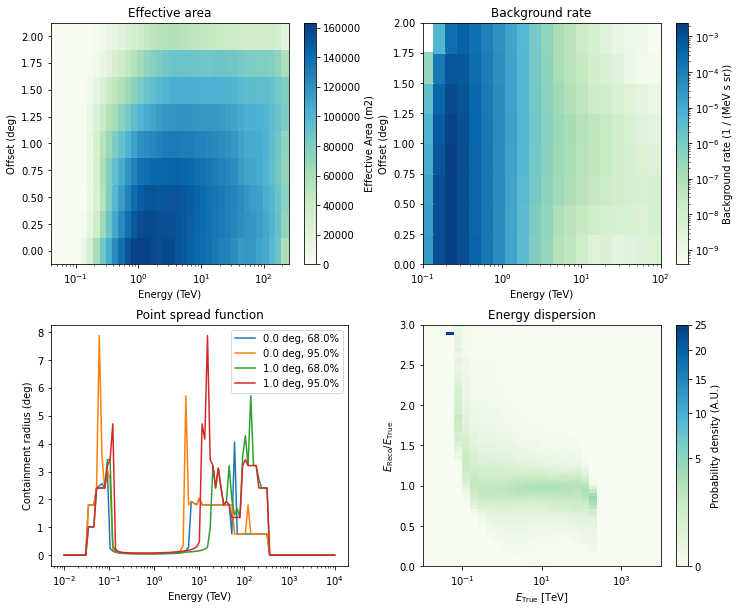

In [21]:
obs = data_store_new.obs(64080)
obs.peek()

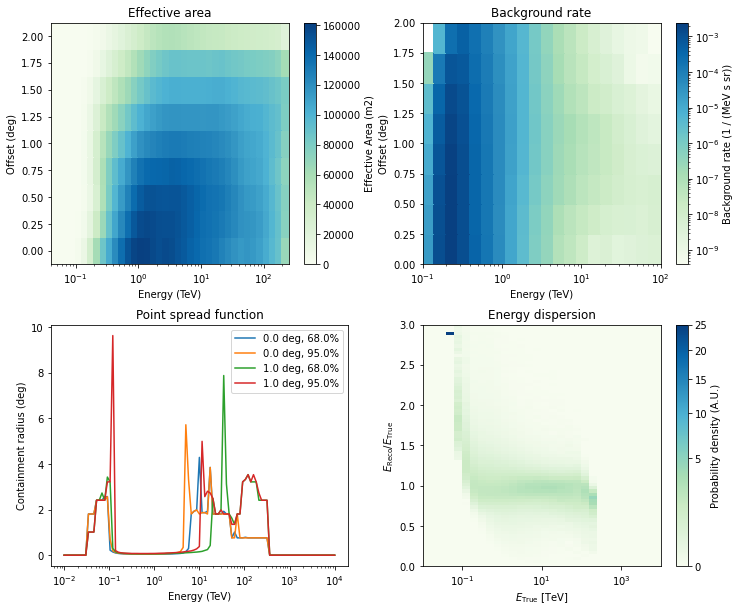

In [22]:
obs = data_store_new.obs(64081)
obs.peek()

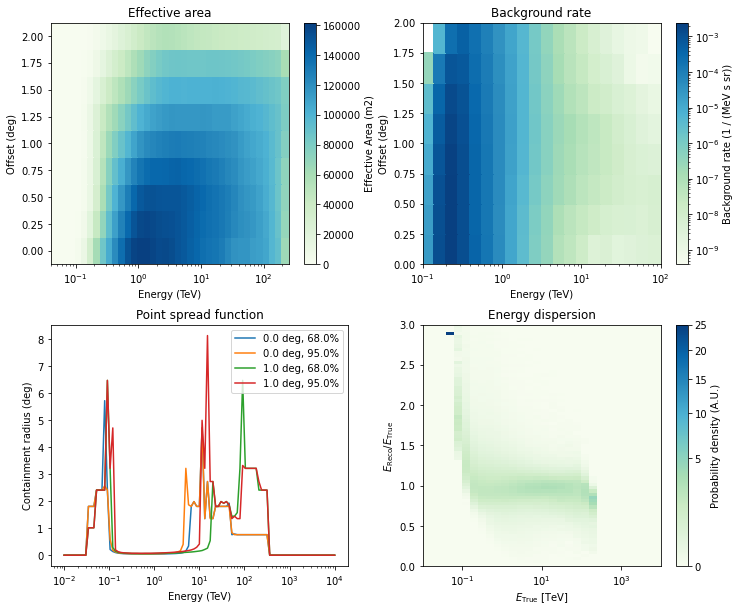

In [23]:
obs = data_store_new.obs(64082)
obs.peek()

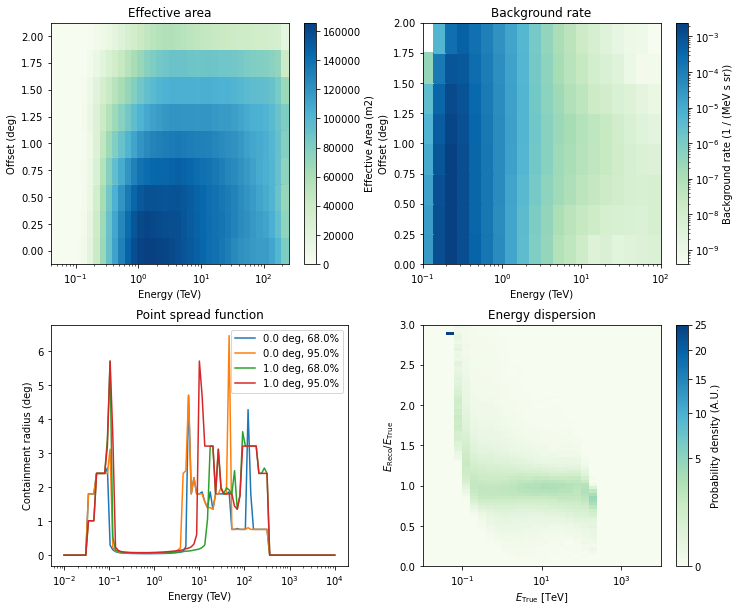

In [24]:
obs = data_store_new.obs(64083)
obs.peek()

In [30]:

df=pd.read_csv('./GAMMAPY/exclusion mask.csv', sep=',',header=None)
ra_list = list(df[0])
dec_list = list(df[1])


region_list = []
for ra, dec in zip(ra_list, dec_list):
    region_list.append(make_region(f"icrs;circle({ra}, {dec}, 0.3)"))
    

exclusion_mask=[]
def exclusion_mask(geom, center_region):
    geom_image = geom
    exclusion_mask=Map.from_geom(geom)
    if center_region not in region_list:
        region_list.append(center_region)
    exclusion_mask.data=geom.region_mask(region_list, inside=False)
    return exclusion_mask

target_position = SkyCoord(ra="05h34m30.9s",dec="+22d00m44.5s", frame="icrs")
print(target_position)
# 0.089
on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)
geom = WcsGeom.create(skydir=target_position, binsz=0.02, width="7 deg", frame="galactic")
center_region = CircleSkyRegion(center=target_position, radius=0.30* u.deg)

exclusion_mask = exclusion_mask(geom, center_region)
exclusion_mask_int = exclusion_mask.copy()
exclusion_mask_int.data = exclusion_mask_int.data.astype(int)
exclusion_mask_int.write(f"/Users/cedrickperron/GAMMAPY/{source}/exclusion_mask_crab.fits", overwrite="True")

<SkyCoord (ICRS): (ra, dec) in deg
    (83.62875, 22.01236111)>


In [29]:
#print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: /Users/cedrickperron/GAMMAPY/crab copy 2/VERITAS-DL3_with_BKG_2D_final.fits.gz
        obs_ids: [64080, 64081, 64082, 64083]
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
    datasets:
        type: 3d
        stack: true
        geom:
            wcs:
                skydir: {frame: galactic, lon: 184.56 deg, lat: -5.79 deg}
                binsize: 0.02 deg
                fov: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.25 deg
            selection: {offset_max: 1.75 deg}
            axes:
                energy: {min: 0.2 TeV, max: 10.0 TeV, nbins: 15}
                energy_true: {min: 0.1 TeV, max: 17.0 TeV, nbins: 20}
        map_selection: [counts, exposure, background, psf, edisp]
        background:

In [26]:
config = AnalysisConfig()
config.observations.obs_ids=[64080,64081,64082,64083]
config.observations.datastore = path

In [36]:
config.datasets.type = "3d"
config.datasets.geom.wcs.skydir = {
    "lon": "184.56 deg",
    "lat": "-5.79 deg",
    "frame": "galactic",
}
config.datasets.geom.wcs.fov = {"width": "5 deg", "height": "5 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"
config.datasets.geom.wcs.binsize_irf = "0.25 deg"
config.datasets.geom.selection.offset_max = 1.75 * u.deg
config.datasets.safe_mask.methods = ["aeff-default"]
config.datasets.safe_mask.parameters = {"aeff_percent":10, "offset_max":"1.75 deg"}
config.datasets.geom.axes.energy.min = "0.2 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 15
config.datasets.geom.axes.energy_true.min = "0.1 TeV"
config.datasets.geom.axes.energy_true.max = "17 TeV"
config.datasets.geom.axes.energy_true.nbins = 20
config.datasets.background.exclusion = (f"/Users/cedrickperron/GAMMAPY/{source}/exclusion_mask_crab.fits")
config.datasets.background.method = "fov_background"
config.datasets.background.parameters = {"method": "scale"}


In [37]:
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: /Users/cedrickperron/GAMMAPY/crab copy 2/VERITAS-DL3_with_BKG_2D_final.fits.gz
        obs_ids: [64080, 64081, 64082, 64083]
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
    datasets:
        type: 3d
        stack: true
        geom:
            wcs:
                skydir: {frame: galactic, lon: 184.56 deg, lat: -5.79 deg}
                binsize: 0.02 deg
                fov: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.25 deg
            selection: {offset_max: 1.75 deg}
            axes:
                energy: {min: 0.2 TeV, max: 10.0 TeV, nbins: 15}
                energy_true: {min: 0.1 TeV, max: 17.0 TeV, nbins: 20}
        map_selection: [counts, exposure, background, psf, edisp]
        background:

In [38]:
config_stack = config.copy(deep=True)
config_stack.datasets.stack = True

config_joint = config.copy(deep=True)
config_joint.datasets.stack = False

In [39]:
config_joint.write(path=f"/Users/cedrickperron/GAMMAPY/{source}/" +"config_joint.yaml", overwrite=True)
config_stack.write(path=f"/Users/cedrickperron/GAMMAPY/{source}/"+ "config_stack.yaml", overwrite=True)


In [40]:
config_stacked = AnalysisConfig.read(path=f"/Users/cedrickperron/GAMMAPY/{source}/"+ "config_stack.yaml")
analysis_stacked = Analysis(config_stacked)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


In [41]:
%%time
# select observations:
analysis_stacked.get_observations()
# run data reduction
analysis_stacked.get_datasets()

Fetching observations.
Number of selected observations: 4
Creating geometry.
Creating datasets.
Processing observation 64080
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Processing observation 64081
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Processing observation 64082
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Processing observation 64083
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/

CPU times: user 5.23 s, sys: 957 ms, total: 6.19 s
Wall time: 6.54 s


In [42]:
dataset_stacked = analysis_stacked.datasets["stacked"]
print(dataset_stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 8331 
  Total background counts         : 7261.77
  Total excess counts             : 1069.23

  Predicted counts                : 7261.77
  Predicted background counts     : 7261.77
  Predicted excess counts         : nan

  Exposure min                    : 1.23e+01 m2 s
  Exposure max                    : 6.13e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 693435 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [43]:
# Plot a smooth counts map
dataset_stacked.counts.smooth(0.02 * u.deg).plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [44]:
dataset_stacked.background.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

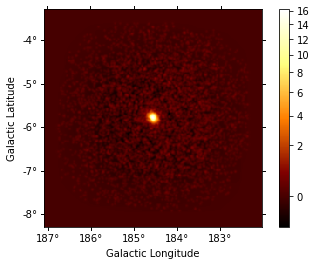

In [45]:
excess = dataset_stacked.excess.sum_over_axes()
excess.smooth("0.02 deg").plot(stretch="sqrt", add_cbar=True);

In [46]:
dataset_stacked.info_dict()


{'name': 'stacked',
 'counts': 8331.0,
 'background': 7261.77,
 'excess': 1069.23,
 'sqrt_ts': 12.257022466253225,
 'npred': 7261.770684016881,
 'npred_background': 7261.77,
 'npred_signal': nan,
 'exposure_min': <Quantity 12.333865 m2 s>,
 'exposure_max': <Quantity 6.1271686e+08 m2 s>,
 'livetime': <Quantity nan s>,
 'ontime': <Quantity 4807.31232393 s>,
 'counts_rate': <Quantity nan 1 / s>,
 'background_rate': <Quantity nan 1 / s>,
 'excess_rate': <Quantity nan 1 / s>,
 'n_bins': 937500,
 'n_fit_bins': 693435,
 'stat_type': 'cash',
 'stat_sum': nan}

In [47]:
coords = dataset_stacked.counts.geom.get_coord()
mask_energy = coords["energy"] > 0.18 * u.TeV
dataset_stacked.mask_fit = Map.from_geom(
    geom=dataset_stacked.counts.geom, data=mask_energy
)

In [51]:
dataset_stacked

In [52]:
target_position = SkyCoord(ra=83.6333, dec=22.0145, unit="deg", frame="icrs")

In [53]:
point_model = PointSpatialModel(lon_0="83.6333 deg", lat_0="22.0145 deg")#, evaluation_radius= "0.05 deg")
#point_model.parameters.free_parameters.freeze_all()
point_model.lat_0.frozen = True
point_model.lon_0.frozen = True
#point_model.lon_0.scale = 1.2

gaussian_model = GaussianSpatialModel(lon_0="83.6333 deg", lat_0="22.0145 deg", sigma="0.07 deg",frame="icrs")
#gaussian_model.parameters.free_parameters.freeze_all()
gaussian_model.sigma.min = 0.1

# disk model
disk_model = DiskSpatialModel(lon_0="83.6333 deg", lat_0="22.0145 deg", r_0="0.08 deg", e= 0.0, phi="0 deg",frame="icrs")
disk_model.r_0.frozen = True
disk_model.r_0.min = 0.05
disk_model.r_0.max = 0.35
#disk_model.lat_0.frozen = False

#### select model
spatial_model = point_model

In [54]:
spectral_model = PowerLawSpectralModel(index=2.59, amplitude=3.2e-11 * u.Unit('1 / (cm2 s TeV)'), reference=1 * u.TeV)
#spectral_model = create_crab_spectral_model('hess_pl')
model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    apply_irf={"exposure": True, "psf": True, "edisp": True},
    name='crab'
)

bkg_model = FoVBackgroundModel(dataset_name="stacked")    ##### https://docs.gammapy.org/dev/makers/fov.html
bkg_model.spectral_model.norm.value = 1
models_stacked = Models([model, bkg_model])
dataset_stacked.models = models_stacked

In [55]:
spatial_model.parameters.free_parameters.names

[]

In [56]:
print(dataset_stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 8331 
  Total background counts         : 7261.77
  Total excess counts             : 1069.23

  Predicted counts                : 8154.53
  Predicted background counts     : 7261.77
  Predicted excess counts         : 892.76

  Exposure min                    : 1.23e+01 m2 s
  Exposure max                    : 6.13e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 693435 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 66263.27

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : crab
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      index          

In [57]:
%%time
fit = Fit([dataset_stacked])
result = fit.run()
#result = fit.run(backend="sherpa")

CPU times: user 2.14 s, sys: 313 ms, total: 2.46 s
Wall time: 2.67 s


In [58]:
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 78
	total stat : 66114.74



In [59]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.8159e+00,,nan,nan,False,5.079e-02
amplitude,3.9016e-11,cm-2 s-1 TeV-1,nan,nan,False,2.099e-12
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
lon_0,8.3633e+01,deg,nan,nan,True,0.000e+00
lat_0,2.2015e+01,deg,-9.000e+01,9.000e+01,True,0.000e+00
norm,9.6514e-01,,nan,nan,False,1.183e-02
tilt,0.0000e+00,,nan,nan,True,0.000e+00
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


In [60]:
spatial_model.evaluation_radius

<Quantity 0. deg>

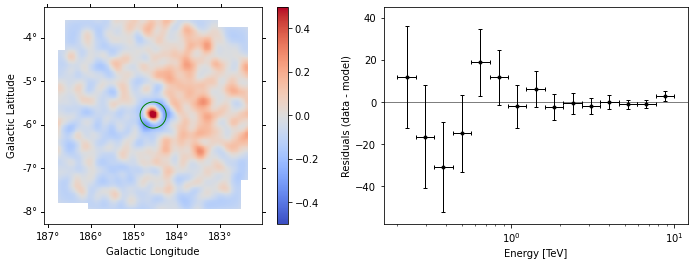

In [61]:
target_position = SkyCoord(ra=83.6333, dec=22.0145, unit="deg", frame="icrs")

region = CircleSkyRegion(target_position, radius=0.3 * u.deg)

plot_res =dataset_stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
);

###
#        “diff” (default): data - model
#        “diff/model”: (data - model) / model
#        “diff/sqrt(model)”: (data - model) / sqrt(model)


In [62]:
# verify fit postion is in agreement
spatial_model.position, target_position

(<SkyCoord (ICRS): (ra, dec) in deg
     (83.6333, 22.0145)>, <SkyCoord (ICRS): (ra, dec) in deg
     (83.6333, 22.0145)>)

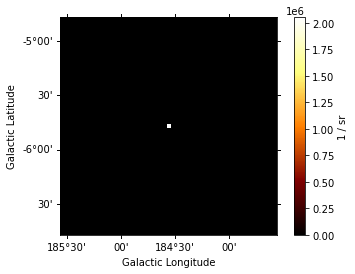

In [63]:
# model plot
model_s = spatial_model
geom = WcsGeom.create(
    skydir=model.position, frame="galactic", width=(2, 2), binsz=0.02
)
ax = model_s.plot(geom=geom, add_cbar=True)


In [64]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.2, 1.0, 10] * u.TeV,
    apply_mask_fit=True
)
result = estimator.run(dataset_stacked)


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


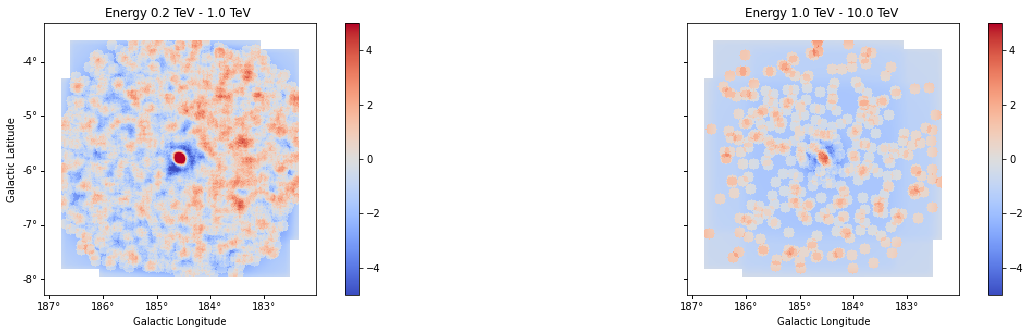

In [65]:
#counts : correlated counts map
#background : correlated background map
#excess : correlated excess map
#ts : TS map
#sqrt_ts : sqrt(delta TS), or Li-Ma significance map
#err : symmetric error map (from covariance)
#flux : flux map. An exposure map must be present in the dataset to compute flux map
#errn : negative error map
#errp : positive error map
#ul : upper limit map

result["sqrt_ts"].plot_grid(
    figsize=(22, 5), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
);

In [66]:
result_d = result["sqrt_ts"].reduce(axis_name="energy")

In [67]:
a=[]
for i in range(0,250):
    a.append(result_d.interp_by_pix(pix=(125,i), fill_value=None))
b=[]
for i in range(0,250):
    b.append(result_d.interp_by_pix(pix=(i,125), fill_value=None))
#result_d.plot(slice={"lon_0":[83.5,83.7]})

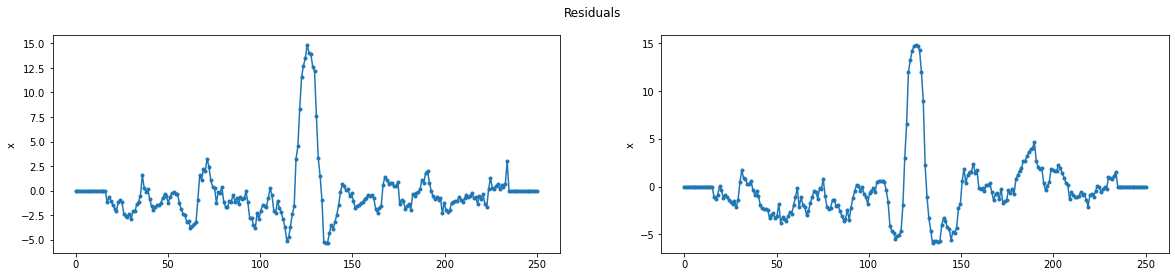

In [68]:
x1 = np.linspace(0.0, 250,250)

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.suptitle('Residuals')
fig.set_figwidth(20)
ax1.plot(x1, a, 'o-',markersize=3)
ax1.set_ylabel('x')
ax2.plot(x1, b, 'o-',markersize=3)
ax2.set_ylabel('x')
plt.show()

In [69]:
e_edges = MapAxis.from_energy_bounds("0.200 TeV", "12.589 TeV", nbin=15).edges

fpe = FluxPointsEstimator(energy_edges=e_edges)
flux_points = fpe.run(datasets=[dataset_stacked])

flux_points_dataset = FluxPointsDataset(data=flux_points, models=dataset_stacked.models)
plt.figure(figsize=(8, 6))

Dataset stacked does not contribute in the energy range


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

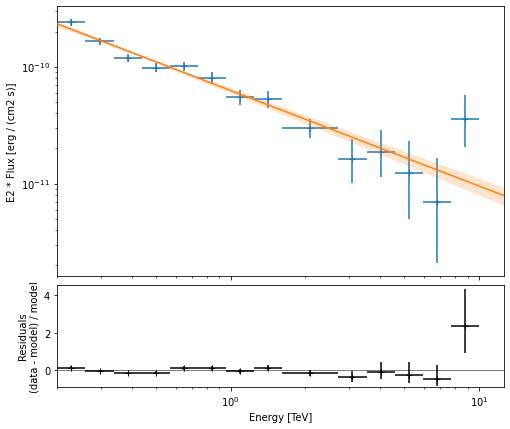

In [70]:
flux_points_dataset.plot_fit();

In [71]:
flux_points.table_formatted

counts [1],e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,norm_errp,norm_errn,norm_ul,norm_scan [11],stat_scan [11],sqrt_ts,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2347,0.228,0.200,0.260,2.512e-09,1.507e-10,3.408e-11,1.304e-10,1.153,16220.606,True,0.077,705.316,0.079,0.076,1.313,0.200 .. 5.000,16538.503 .. 17183.295,26.558,2.896e-09,3.298e-09,1.938e-10,1.974e-10,1.903e-10
2376,0.296,0.260,0.337,1.205e-09,9.383e-11,2.755e-11,1.054e-10,0.979,16719.549,True,0.068,649.611,0.069,0.067,1.121,0.200 .. 5.000,16980.923 .. 17909.743,25.487,1.180e-09,1.351e-09,8.188e-11,8.348e-11,8.035e-11
1354,0.384,0.337,0.437,5.783e-10,5.844e-11,2.227e-11,8.521e-11,0.863,10851.508,True,0.068,534.720,0.070,0.067,1.006,0.200 .. 5.000,11036.307 .. 11948.739,23.124,4.989e-10,5.815e-10,3.950e-11,4.040e-11,3.861e-11
826,0.498,0.437,0.568,2.774e-10,3.639e-11,1.800e-11,6.888e-11,0.888,7355.681,True,0.079,471.836,0.081,0.077,1.054,0.200 .. 5.000,7510.193 .. 8167.675,21.722,2.463e-10,2.925e-10,2.195e-11,2.253e-11,2.138e-11
580,0.647,0.568,0.737,1.331e-10,2.266e-11,1.455e-11,5.568e-11,1.132,5314.996,True,0.102,556.921,0.105,0.099,1.346,0.200 .. 5.000,5512.875 .. 5824.890,23.599,1.506e-10,1.792e-10,1.354e-11,1.391e-11,1.317e-11
354,0.839,0.737,0.956,6.387e-11,1.411e-11,1.176e-11,4.501e-11,1.113,3552.134,True,0.122,378.812,0.126,0.118,1.374,0.200 .. 5.000,3681.628 .. 3907.191,19.463,7.110e-11,8.777e-11,7.808e-12,8.070e-12,7.550e-12
223,1.090,0.956,1.241,3.064e-11,8.789e-12,9.506e-12,3.638e-11,0.945,2487.227,True,0.138,227.357,0.145,0.132,1.247,0.200 .. 5.000,2551.569 .. 2751.007,15.078,2.896e-11,3.821e-11,4.237e-12,4.428e-12,4.048e-12
120,1.414,1.241,1.611,1.470e-11,5.474e-12,7.684e-12,2.941e-11,1.120,1412.766,True,0.184,206.157,0.193,0.174,1.525,0.200 .. 5.000,1473.634 .. 1566.298,14.358,1.646e-11,2.243e-11,2.700e-12,2.840e-12,2.563e-12


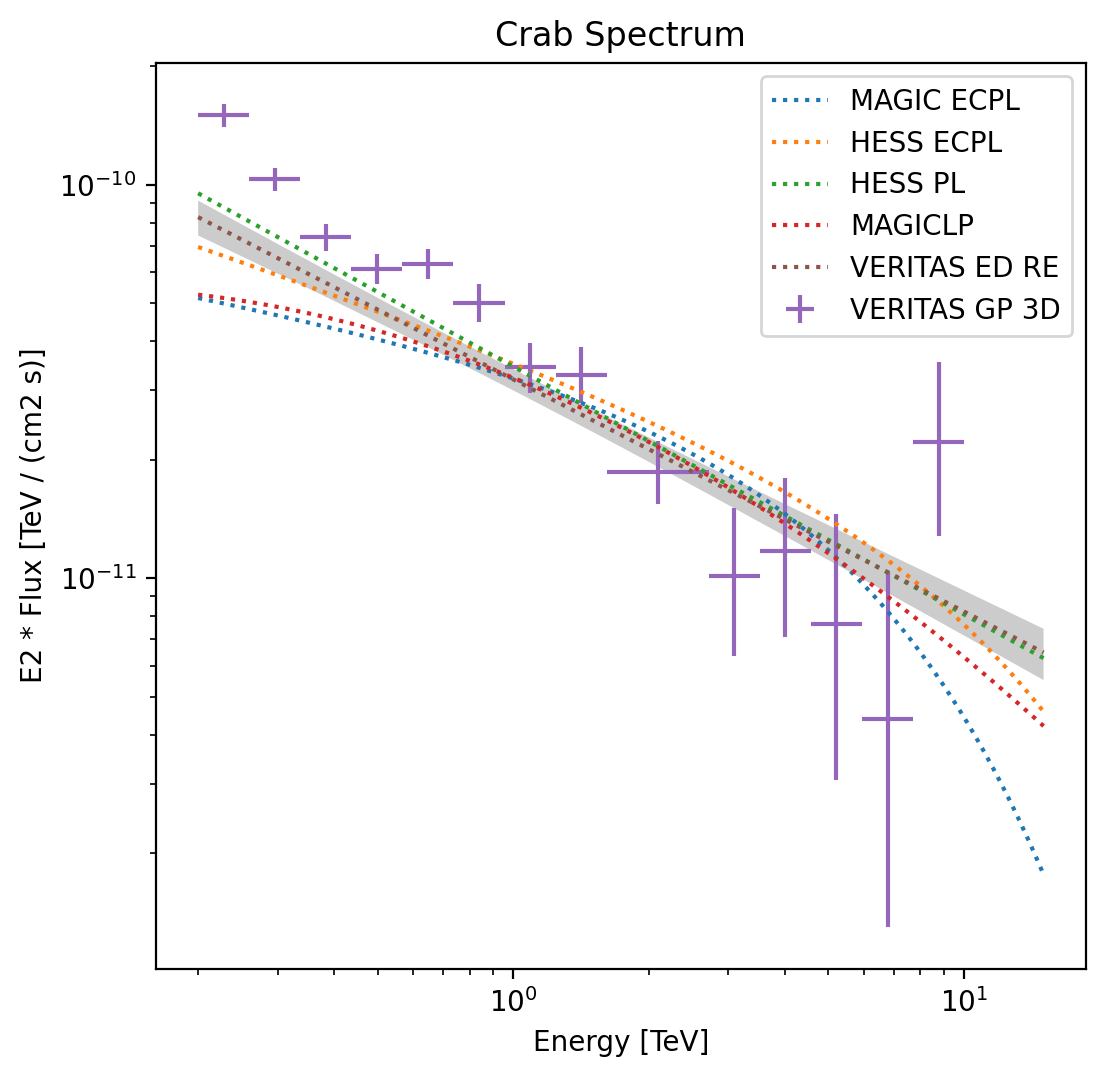

In [72]:
fig = plt.figure(figsize=(6, 6),dpi=200)

plot_kwargs = {
    "energy_range": [0.2, 15] * u.TeV,
    "energy_power": 2,
    "flux_unit": "TeV-1 cm-2 s-1",
    'ls':'dotted',
}
create_crab_spectral_model("magic_ecpl").plot(
    **plot_kwargs, label="MAGIC ECPL"
)
create_crab_spectral_model("hess_ecpl").plot(
    **plot_kwargs, label="HESS ECPL"
)
create_crab_spectral_model("hess_pl").plot(
    **plot_kwargs, label="HESS PL"
)
create_crab_spectral_model("magic_lp").plot(
    **plot_kwargs, label="MAGICLP"
)
ax = flux_points.plot(
    energy_power=2., flux_unit="TeV-1 cm-2 s-1",
    label='VERITAS GP 3D'
)
#ax.errorbar(
#        x     = ED['<E>'],
#        xerr  = ED['<E>']-ED["E_min"],
#        y     = ED['dN/dE']*ED['<E>']**2,
#        yerr  = ED["Err"]*ED['<E>']**2,
#        label = "ED",
#        ls    = '',
#        marker= 'o',
#        color = 'C3',
#        ms='2',
#    )
pwl = PowerLawSpectralModel(index=2.59, amplitude=3.2e-11 * u.Unit('1 / (cm2 s TeV)'))
pwl.amplitude.error = 0.2e-11
pwl.index.error = 0.05
pwl.plot_error(**plot_kwargs)
###
# power law fit for gammapy result
#pwl_gammapy = PowerLawSpectralModel(index=2.7, amplitude=3.2e-11 * u.Unit('1 / (cm2 s TeV)'))

pwl.plot(**plot_kwargs, label="VERITAS ED RE")
#pwl_gammapy.plot(**plot_kwargs, label="gammapy")
plt.title('Crab Spectrum')
plt.legend()

In [75]:
%%time

# Read the yaml file from disk
config_joint = AnalysisConfig.read(path=f"/Users/cedrickperron/GAMMAPY/{source}/"+ "config_joint.yaml")
analysis_joint = Analysis(config_joint)

# select observations:
analysis_joint.get_observations()

# run data reduction
analysis_joint.get_datasets()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Number of selected observations: 4
Creating geometry.
Creating datasets.
Processing observation 64080
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Processing observation 64081
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Processing observation 64082
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, meth

CPU times: user 5.13 s, sys: 912 ms, total: 6.05 s
Wall time: 6.79 s


In [76]:
print(analysis_joint.datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : ywciWhJK
  Instrument : VERITAS
  Models     : ['ywciWhJK-bkg']

Dataset 1: 

  Type       : MapDataset
  Name       : kyyWfLuL
  Instrument : VERITAS
  Models     : ['kyyWfLuL-bkg']

Dataset 2: 

  Type       : MapDataset
  Name       : DA4ob7Mc
  Instrument : VERITAS
  Models     : ['DA4ob7Mc-bkg']

Dataset 3: 

  Type       : MapDataset
  Name       : F0aGjE8t
  Instrument : VERITAS
  Models     : ['F0aGjE8t-bkg']




In [77]:
print(analysis_joint.datasets[0])

MapDataset
----------

  Name                            : ywciWhJK 

  Total counts                    : 2110 
  Total background counts         : 1330.18
  Total excess counts             : 779.82

  Predicted counts                : 1838.21
  Predicted background counts     : 1838.21
  Predicted excess counts         : 0.00

  Exposure min                    : 3.52e+01 m2 s
  Exposure max                    : 1.63e+08 m2 s

  Number of total bins            : 459375 
  Number of fit bins              : 459375 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 22599.85

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : ywciWhJK-bkg
    Datasets names            : ['ywciWhJK']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.382              
      tilt         (fr

In [78]:
analysis_joint.datasets.info_table()

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str8,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
ywciWhJK,2110.0,1330.1849404435711,779.8150595564289,19.68122721372795,1838.2094406918538,1838.2094406918538,0.0,35.22369276887948,162871744.0028526,nan,1201.8021302819252,nan,nan,nan,459375,459375,cash,22599.847736157524
kyyWfLuL,2060.0,1330.2370000032254,729.7629999967746,18.502727057883877,1781.2827951480954,1781.2827951480954,0.0,61.53018703624849,161997010.78969562,nan,1201.8844868838787,nan,nan,nan,459375,459375,cash,22315.578590755485
DA4ob7Mc,2009.0,1330.201657036565,678.7983429634351,17.29309803831146,1776.0829857752733,1776.0829857752733,0.0,12.333864967119352,161809148.70831084,nan,1201.8256025612354,nan,nan,nan,459375,459375,cash,21856.425012388143
F0aGjE8t,2152.0,1330.1728183666696,821.8271816333304,20.662822087621013,1866.1954631122796,1866.1954631122796,0.0,3.6290063518005518,166428739.2443328,nan,1201.8001041710377,nan,nan,nan,459375,459375,cash,23013.54745231011


In [79]:
models_joint = Models()

model_joint = model.copy(name="crab")
models_joint.append(model_joint)

for dataset in analysis_joint.datasets:
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    models_joint.append(bkg_model)

print(models_joint)

Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.816              
    amplitude               :   3.90e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   :  83.633  deg         
    lat_0        (frozen)   :  22.015  deg         

Component 1: FoVBackgroundModel

  Name                      : ywciWhJK-bkg
  Datasets names            : ['ywciWhJK']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 2: FoVBackgroundModel

  Name                      : kyyWfLuL-bkg
  Datasets names            : ['kyyWfLuL']
  Spectral model type 

In [80]:
analysis_joint.datasets.models = models_joint

In [81]:
%%time
fit_joint = Fit(analysis_joint.datasets)
result_joint = fit_joint.run()

CPU times: user 10.8 s, sys: 943 ms, total: 11.7 s
Wall time: 13.3 s


In [82]:
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 163
	total stat : 85903.95



In [83]:
print(models_joint)

Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.817              
    amplitude               :   3.89e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   :  83.633  deg         
    lat_0        (frozen)   :  22.015  deg         

Component 1: FoVBackgroundModel

  Name                      : ywciWhJK-bkg
  Datasets names            : ['ywciWhJK']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.337              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 2: FoVBackgroundModel

  Name                      : kyyWfLuL-bkg
  Datasets names            : ['kyyWfLuL']
  Spectral model type 

In [84]:
stacked = MapDataset.from_geoms(**dataset_stacked.geoms)

for dataset in analysis_joint.datasets:
    # TODO: Apply mask_fit before stacking
    stacked.stack(dataset)

stacked.models = [model_joint]

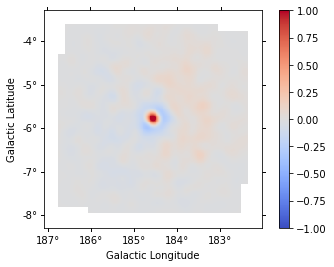

In [85]:
stacked.plot_residuals_spatial(vmin=-1, vmax=1);

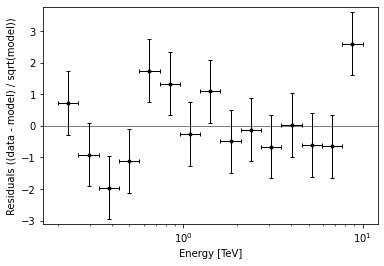

In [86]:
stacked.plot_residuals_spectral(region=region, method='diff/sqrt(model)')

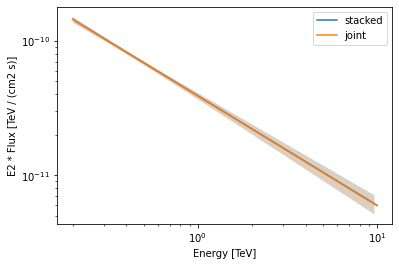

In [87]:
def plot_spectrum(model, result, label, color):
    spec = model.spectral_model
    energy_range = [0.2, 10] * u.TeV
    spec.plot(
        energy_range=energy_range, energy_power=2, label=label, color=color
    )
    spec.plot_error(energy_range=energy_range, energy_power=2, color=color)
plot_spectrum(model, result, label="stacked", color="tab:blue")
plot_spectrum(model_joint, result_joint, label="joint", color="tab:orange")
plt.legend()

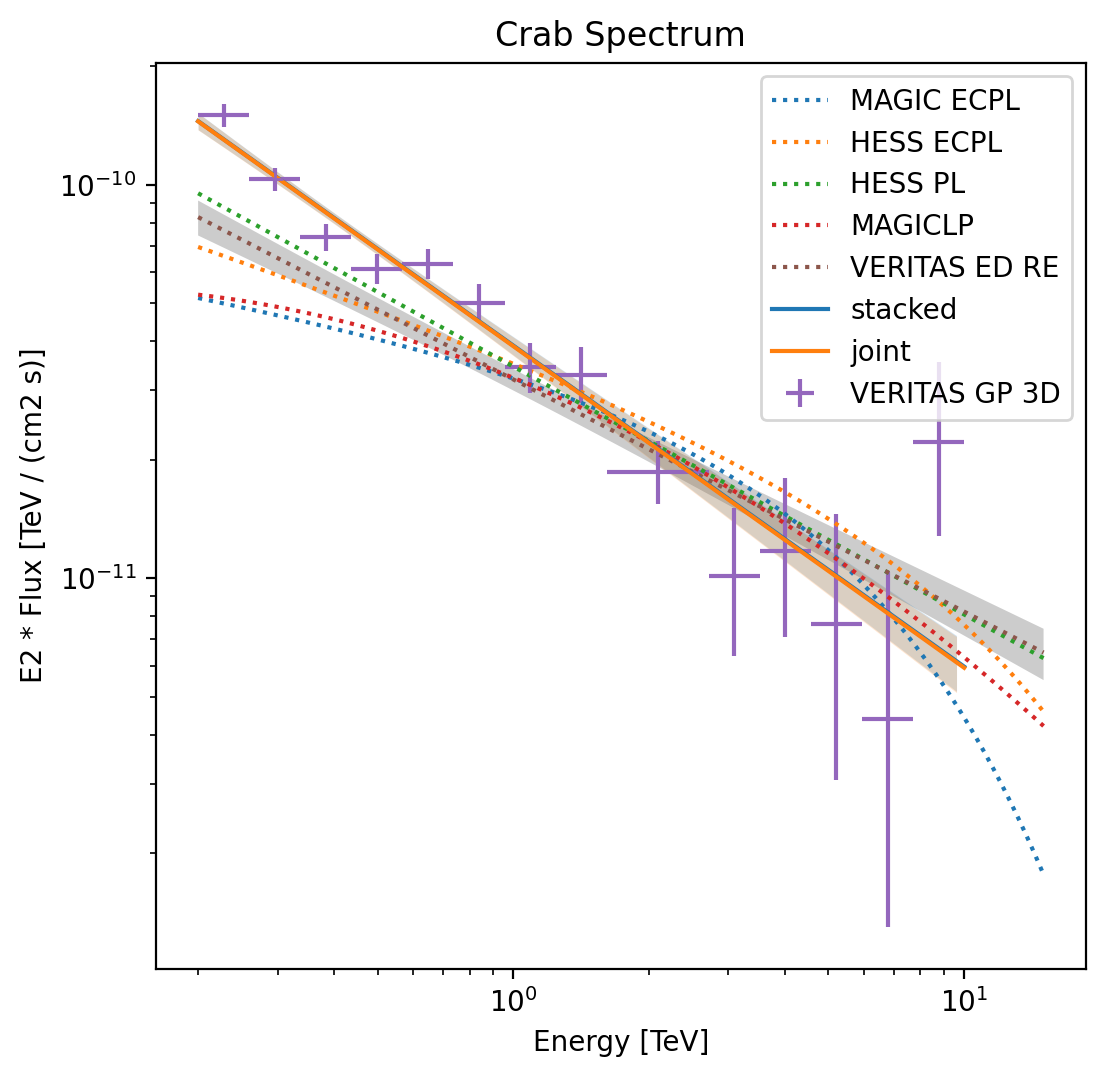

In [88]:
fig = plt.figure(figsize=(6, 6),dpi=200)

plot_kwargs = {
    "energy_range": [0.2, 15] * u.TeV,
    "energy_power": 2,
    "flux_unit": "TeV-1 cm-2 s-1",
    'ls':'dotted',
}
create_crab_spectral_model("magic_ecpl").plot(
    **plot_kwargs, label="MAGIC ECPL"
)
create_crab_spectral_model("hess_ecpl").plot(
    **plot_kwargs, label="HESS ECPL"
)
create_crab_spectral_model("hess_pl").plot(
    **plot_kwargs, label="HESS PL"
)
create_crab_spectral_model("magic_lp").plot(
    **plot_kwargs, label="MAGICLP"
)

ax = flux_points.plot(
    energy_power=2., flux_unit="TeV-1 cm-2 s-1",
    label='VERITAS GP 3D'
)
pwl = PowerLawSpectralModel(index=2.59, amplitude=3.2e-11 * u.Unit('1 / (cm2 s TeV)'))
pwl.plot(**plot_kwargs, label="VERITAS ED RE")
pwl.amplitude.error = 0.2e-11
pwl.index.error = 0.05
pwl.plot_error(**plot_kwargs)

plot_spectrum(model, result, label="stacked", color="tab:blue")
plot_spectrum(model_joint, result_joint, label="joint", color="tab:orange")

plt.title('Crab Spectrum')
plt.legend()
plt.savefig('crab_spectrum_3d.pdf',dpi=300,bb_inches='tight')